In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import bambi as bmb
from bambi.plots import plot_comparison, comparisons

%load_ext autoreload
%autoreload 2

### mtcars

In [164]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data["am"] = pd.Categorical(data["am"], categories=[0, 1], ordered=True)
#data["drat"] = pd.Categorical(data["drat"], ordered=True).codes

In [165]:
# Define and fit the Bambi model
mt_model = bmb.Model("mpg ~ hp * drat * am", data)
mt_idata = mt_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, drat, hp:drat, am, hp:am, drat:am, hp:drat:am]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [166]:
az.summary(mt_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,13.199,13.415,-13.335,37.366,0.354,0.251,1435.0,1685.0,1.00
hp,-0.014,0.084,-0.179,0.141,0.002,0.002,1331.0,1775.0,1.01
drat,3.735,3.797,-3.023,11.266,0.101,0.073,1410.0,1726.0,1.00
hp:drat,-0.012,0.025,-0.057,0.037,0.001,0.000,1348.0,1806.0,1.00
am[1],2.029,14.087,-22.234,30.039,0.358,0.253,1550.0,2032.0,1.00
hp:am[1],0.055,0.089,-0.112,0.220,0.002,0.002,1469.0,2046.0,1.00
drat:am[1],0.357,3.614,-6.505,6.869,0.098,0.069,1357.0,1737.0,1.00
hp:drat:am[1],-0.013,0.025,-0.056,0.035,0.001,0.000,1378.0,2069.0,1.00
mpg_sigma,3.079,0.449,2.311,3.940,0.009,0.006,2715.0,2410.0,1.00


Like `plot_cap` the user must also pass the `model` and `idata`. However, for `plot_comparisons`, the user needs to pass a `contrast_predictor` and `conditional` argument. `contrast_predictor` is the variable whose contrast we are interested in computing comparisons (the difference between predictions) for. `conditional` is the variable that we are conditioning on.

Currently, the `plot_comparisons` function allows the user to pass either `str`, `list`, or `dict` into `contrast_predictor` and `conditional`. A `dict` is used to compare predictions of user defined contrasts. I think this data structure is a good representation since the key, value pair reads as "predictor" : "contrast". If a `str` or `list` is passed, the function will use a grid based on the observed data.

To compute the contrasts, the cartesian product (cross join) is used to compute all pairwise combinations of the `contrast_predictor` and `conditional` variables which is stored as a dataframe. This dataframe, like the `create_cap_data` dataframe, is used as the new data for the model to perform predictions. To compute the difference in predictions (comparison) of the contrasts, multiple pandas methods are chained:
1. `.groupby()` is used to group the dataframe by the covariates in the model (excluding the contrast predictor)
2. `.diff()` is used to compute the difference between the predictions of the contrasts
3. `.dropna()` is used to remove the first row of each group since the difference is computed between the current row and the previous row
4. `.reset_index()` is used to reset the index of the dataframe

The result of steps 1-4 are saved in a new dataframe—`contrast_comparison`. Conditional variable values are added to the dataframe and the dataframe is passed to `plot_comparison` to plot the comparisons.

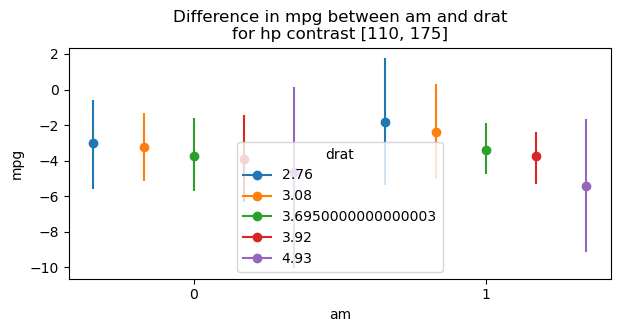

In [167]:
# user defined contrast for `hp`
# grid is determined for `am` and `drat`
# HDI does not include the mean contrast comparison...
fig, ax = plot_comparison(
    mt_model,
    mt_idata,
    contrast={"hp": [110, 175]},
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp contrast [110, 175]");

In [168]:
# can also use the `comparisons` function to get the data
contrast_df = comparisons(
    mt_model,
    mt_idata,
    contrast={"hp": [110, 175]},
    conditional=["am", "drat"]
)

contrast_df

,am,drat,term,contrast,estimate,hdi_3%,hdi_97%
0,0,2.760,hp,"[110, 175]",-3.003375,-5.593993,-0.568978
1,0,3.080,hp,"[110, 175]",-3.248436,-5.148033,-1.303754
2,0,3.695,hp,"[110, 175]",-3.719413,-5.687606,-1.622067
3,0,3.920,hp,"[110, 175]",-3.891722,-6.353025,-1.410411
4,0,4.930,hp,"[110, 175]",-4.665196,-10.054293,0.165007
5,1,2.760,hp,"[110, 175]",-1.852925,-5.365456,1.761705
6,1,3.080,hp,"[110, 175]",-2.377722,-5.056491,0.303561
7,1,3.695,hp,"[110, 175]",-3.386315,-4.777955,-1.855343
8,1,3.920,hp,"[110, 175]",-3.755313,-5.298154,-2.399914
9,1,4.930,hp,"[110, 175]",-5.411702,-9.164244,-1.660356


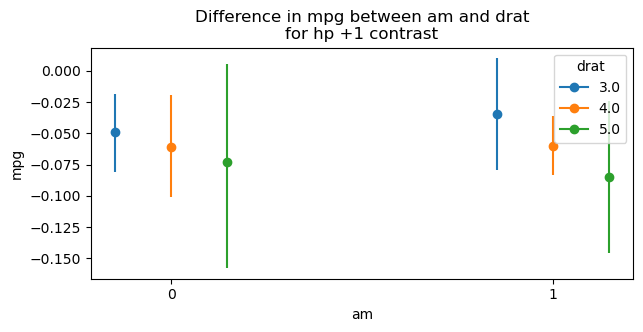

In [169]:
# HDI does not include the mean contrast comparison...
fig, ax = plot_comparison(
    mt_model,
    mt_idata,
    contrast="hp",
    #conditional=["am", "drat"]
    conditional={"am": [0, 1], "drat": [3, 4, 5]}
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp +1 contrast");

In [170]:
condiional = {"horizontal": "hp", "color": "am", "panel": "am"}

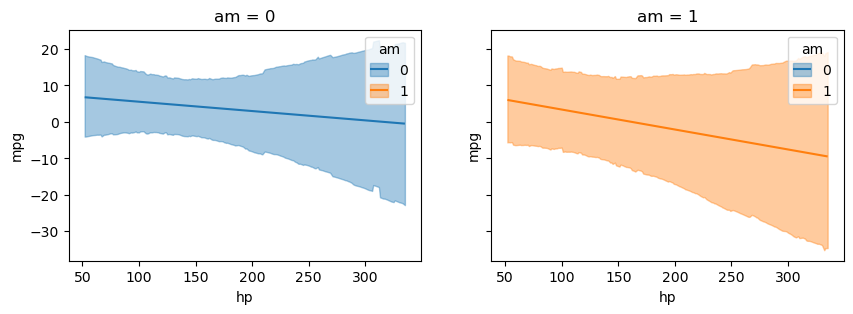

In [171]:
fig, ax = plot_comparison(
    mt_model,
    mt_idata,
    contrast={"drat": [2.76, 4.93]},
    conditional=["hp", "am"],
    subplot_kwargs={"main": "hp", "group": "am", "panel": "am"},
    fig_kwargs={"figsize": (10, 3), "sharey": True}
)
#plt.title("Difference in mpg between am and drat\nfor hp +1 contrast");

### Palmer penguins

In [12]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/palmerpenguins/penguins.csv", index_col=0)
data = data.dropna(axis=0, how="any")

In [13]:
data["species"] = pd.Categorical(data["species"], )
data["island"] = pd.Categorical(data["island"])

In [14]:
penguin_model = bmb.Model(
    "body_mass_g ~ flipper_length_mm * species * bill_length_mm + island",
    data, family="gaussian"
)
penguin_idata = penguin_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, Intercept, flipper_length_mm, species, flipper_length_mm:species, bill_length_mm, flipper_length_mm:bill_length_mm, species:bill_length_mm, flipper_length_mm:species:bill_length_mm, island]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.


Currently, the difference in predictions is computed off of point estimate (mean of draws, chains) whereas the HDI is computed using posterior. Thus, the reason for HDI and mean difference not matching.

In [ ]:
{
    "horizontal": {"bill_length_mm": np.arange(40, 50, 1)}, 
    "color": {"species": ["Adelie", "Chinstrap", "Gentoo"]}, 
    "panel": {"species": ["Adelie", "Chinstrap", "Gentoo"]}
}

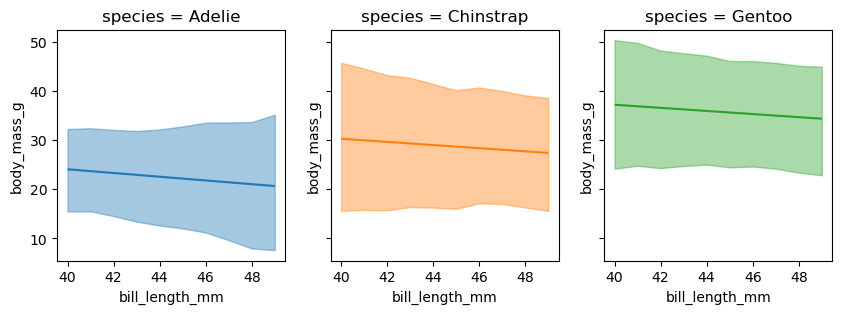

In [34]:
fig, ax = plot_comparison(
    model=penguin_model,
    idata=penguin_idata,
    contrast=["flipper_length_mm"],
    conditional={
        "bill_length_mm": np.arange(40, 50, 1), 
        "species": ["Adelie", "Chinstrap", "Gentoo"]
        },
    subplot_kwargs={"main": "bill_length_mm", "group": "species", "panel": "species"},
    fig_kwargs={"figsize": (10, 3), "sharey": True},
    legend=False
)

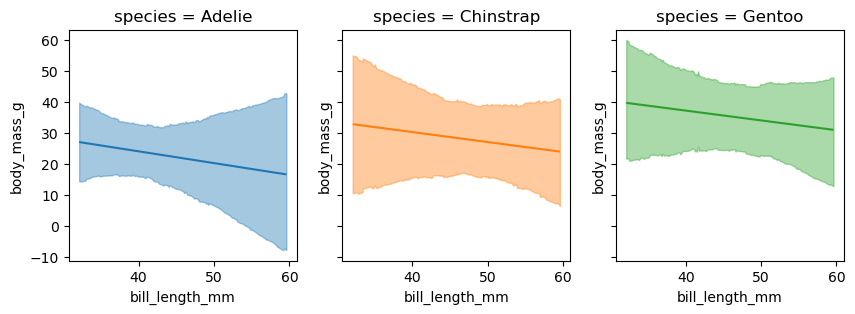

In [35]:
# not the same as marginaleffects docs.
fig, ax = plot_comparison(
    model=penguin_model,
    idata=penguin_idata,
    contrast=["flipper_length_mm"],
    conditional=["bill_length_mm", "species"],
    subplot_kwargs={"main": "bill_length_mm", "group": "species", "panel": "species"},
    fig_kwargs={"figsize": (10, 3), "sharey": True},
    legend=False
)

In [16]:
contrast_df = comparisons(
    model=penguin_model,
    idata=penguin_idata,
    contrast_predictor=["flipper_length_mm"],
    conditional=["bill_length_mm", "species"],
)

In [111]:
contrast_df = contrast_df.rename(columns={
    "pred_estimate": "predicted_bambi",
    "estimate": "estimate_bambi",
    "hdi_3%": "estimate_hdi_3%_bambi",
    "hdi_97%": "estimate_hdi_97%_bambi",
})

In [103]:
datplot = pd.read_csv("/Users/gabestechschulte/Downloads/datplot.csv")
datplot.drop(columns="rowid", inplace=True)

In [104]:
cols = ["estimate", "predicted", "predicted_hi", "predicted_lo", "island", "bill_length_mm", "species"]
datplot = datplot[cols].rename(columns={
    "estimate": "estimate_R",
    "predicted": "predicted_R",
    "predicted_hi": "predicted_hi_R",
    "predicted_lo": "predicted_lo_R",
    "bill_length_mm": "bill_length_mm_R",
    "species": "species_R",
    "island": "island_R"
    }
)

datplot["species_R"] = pd.Categorical(datplot["species_R"])
datplot["island_R"] = pd.Categorical(datplot["island_R"])

In [107]:
# concat contrast_df and datplot column wise
compare_r_bambi = pd.concat([
    contrast_df.sort_values(by=["bill_length_mm", "species"]).reset_index(drop=True),
    datplot.sort_values(by=["bill_length_mm_R", "species_R"]).reset_index(drop=True)
], axis=1)

cols = [
    "term",
    "contrast",
    "bill_length_mm", "bill_length_mm_R",
    "species", "species_R",
    "island", "island_R",
    "estimate_bambi", "estimate_R",
    "predicted_bambi", "predicted_R"
    ""
]
compare_r_bambi_sub = compare_r_bambi[cols]

In [109]:
compare_r_bambi_sub.head(20)

,term,contrast,bill_length_mm,bill_length_mm_R,species,species_R,island,island_R,estimate_bambi,estimate_R,predicted_bambi,predicted_R
0,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",32.100000,32.100000,Adelie,Adelie,Biscoe,Biscoe,27.068395,35.396905,3511.827531,3597.943730
1,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",32.100000,32.100000,Chinstrap,Chinstrap,Biscoe,Biscoe,32.841295,-7.449954,3360.102335,3020.174512
2,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",32.100000,32.100000,Gentoo,Gentoo,Biscoe,Biscoe,39.724979,95.677222,3512.537486,2533.250553
3,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",32.661224,32.661224,Adelie,Adelie,Biscoe,Biscoe,26.855235,34.444157,3551.399999,3631.462232
4,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",32.661224,32.661224,Chinstrap,Chinstrap,Biscoe,Biscoe,32.660583,-6.339848,3377.033844,3048.077452
5,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",32.661224,32.661224,Gentoo,Gentoo,Biscoe,Biscoe,39.547309,93.590778,3548.818628,2605.013405
6,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",33.222449,33.222449,Adelie,Adelie,Biscoe,Biscoe,26.642075,33.491409,3590.972467,3664.980733
7,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",33.222449,33.222449,Chinstrap,Chinstrap,Biscoe,Biscoe,32.479872,-5.229741,3393.965353,3075.980391
8,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",33.222449,33.222449,Gentoo,Gentoo,Biscoe,Biscoe,39.369639,91.504333,3585.099771,2676.776257
9,flipper_length_mm,"[200.46696696696696, 201.46696696696696]",33.783673,33.783673,Adelie,Adelie,Biscoe,Biscoe,26.428915,32.538661,3630.544935,3698.499234


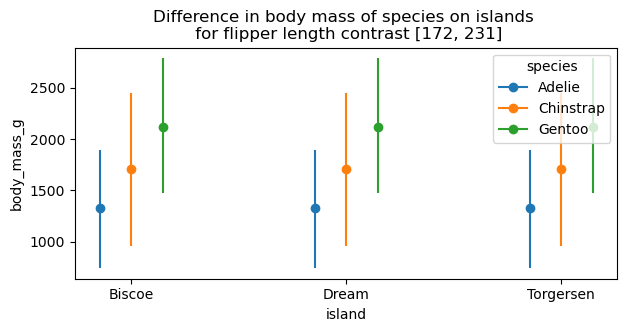

In [163]:
# default vals for conditional since they are not specified
fig, ax = plot_comparison(
    model=penguin_model,
    idata=penguin_idata,
    contrast={"flipper_length_mm": [172, 231]},
    conditional=["island", "species"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in body mass of species on islands \n for flipper length contrast [172, 231]");

### Titanic

In [3]:
dat = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", index_col=0)

In [4]:
dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["SexCode"] = pd.Categorical(dat["SexCode"], ordered=True)
dat = dat.dropna(axis=0, how="any")

In [5]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age", 
    data=dat, 
    family="bernoulli"
)
titanic_idata = titanic_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Modeling the probability that Survived==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PClass, SexCode, PClass:SexCode, Age, PClass:Age, SexCode:Age, PClass:SexCode:Age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [6]:
az.summary(titanic_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.557,0.592,0.455,2.658,0.014,0.010,1898.0,2500.0,1.0
PClass[2.0],0.188,0.904,-1.491,1.885,0.022,0.016,1594.0,2342.0,1.0
PClass[3.0],-2.038,0.776,-3.495,-0.588,0.018,0.013,1795.0,2306.0,1.0
SexCode[1],1.090,1.238,-1.199,3.418,0.036,0.026,1201.0,1871.0,1.0
"PClass:SexCode[2.0, 1]",0.176,1.644,-2.901,3.206,0.047,0.033,1212.0,2053.0,1.0
"PClass:SexCode[3.0, 1]",-0.801,1.381,-3.434,1.792,0.040,0.028,1245.0,1785.0,1.0
Age,-0.056,0.015,-0.082,-0.027,0.000,0.000,1856.0,2411.0,1.0
PClass:Age[2.0],-0.090,0.033,-0.156,-0.030,0.001,0.001,1749.0,2195.0,1.0
PClass:Age[3.0],0.003,0.025,-0.044,0.049,0.001,0.000,1935.0,2673.0,1.0
SexCode:Age[1],0.069,0.032,0.010,0.128,0.001,0.001,1318.0,1865.0,1.0


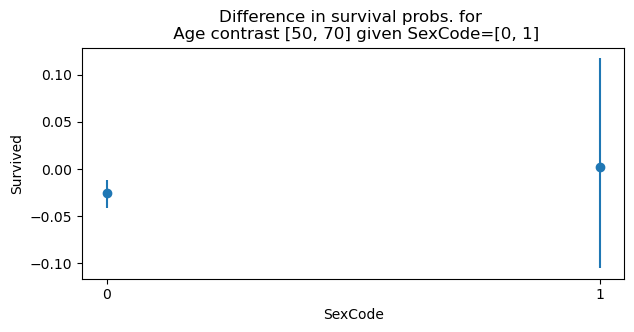

In [7]:
# user provided contrast for `Age` and default for conditional
fig, ax = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast={"Age": [50, 70]},
    conditional="SexCode",
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n Age contrast [50, 70] given SexCode=[0, 1]");

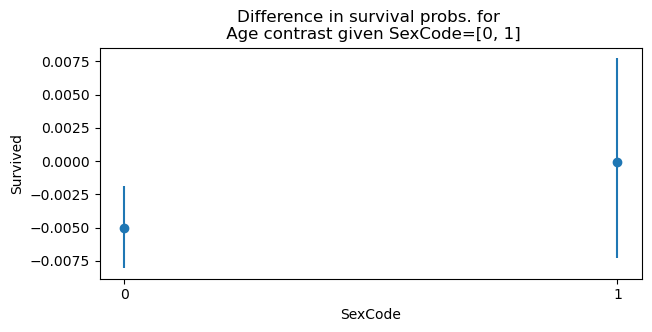

In [8]:
# default vals for both contrast and conditional
fig, ax = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast="Age",
    conditional="SexCode",
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n Age contrast given SexCode=[0, 1]");

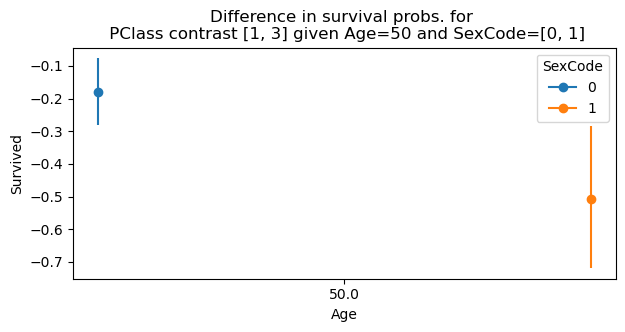

In [9]:
# user can also pass a dict into conditional to define the 
# values used for the conditional variables
fig, ax = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast={"PClass": [1, 3]},
    conditional={"Age": [50], "SexCode": [0, 1]},
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n PClass contrast [1, 3] given Age=50 and SexCode=[0, 1]");

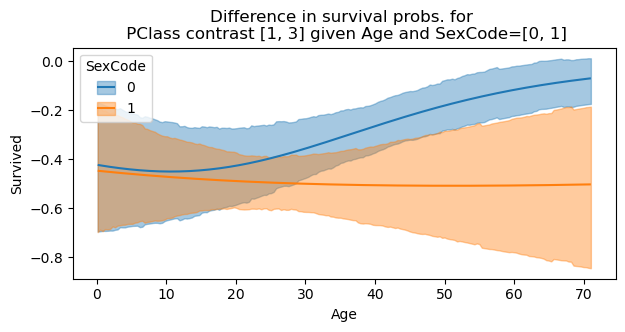

In [162]:
# default vals for numeric and categorical conditional variables
fig, ax = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast={"PClass": [1, 3]},
    conditional=["Age", "SexCode"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n PClass contrast [1, 3] given Age and SexCode=[0, 1]");

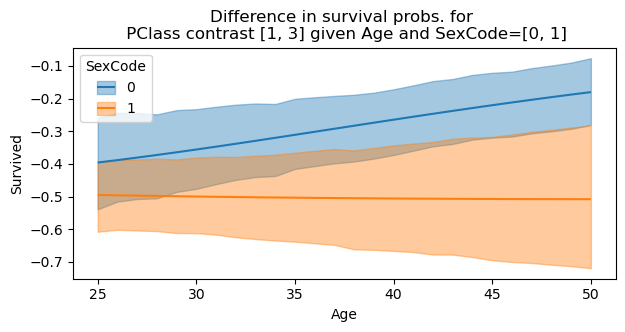

In [161]:
# default vals for numeric and categorical conditional variables
fig, ax = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast={"PClass": [1, 3]},
    # conditional=["Age", "SexCode"]
    conditional={"Age": np.arange(25,51,1), "SexCode": [0, 1]},
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n PClass contrast [1, 3] given Age and SexCode=[0, 1]");

## Negative Binomial Model

In [25]:
# Load data, define and fit Bambi model
data = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")
data["prog"] = data["prog"].map({1: "General", 2: "Academic", 3: "Vocational"})

model_interaction = bmb.Model(
    "daysabs ~ 0 + prog + scale(math) + prog:scale(math)",
    data,
    family="negativebinomial"
)
idata_interaction = model_interaction.fit(
    draws=1000, target_accept=0.95, random_seed=1234, chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [daysabs_alpha, prog, scale(math), prog:scale(math)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


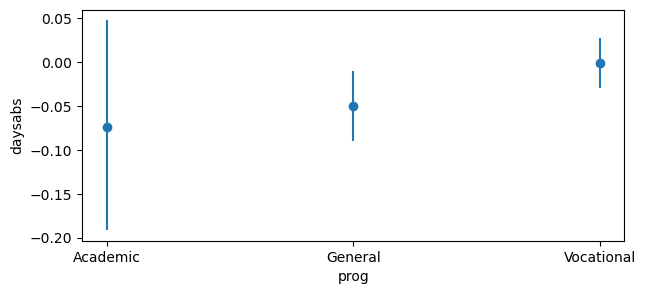

In [250]:
fig, ax = plot_comparison(
    model=model_interaction,
    idata=idata_interaction,
    contrast="math",
    conditional={"prog": ["General", "Academic", "Vocational"]},
)
fig.set_size_inches(7, 3)

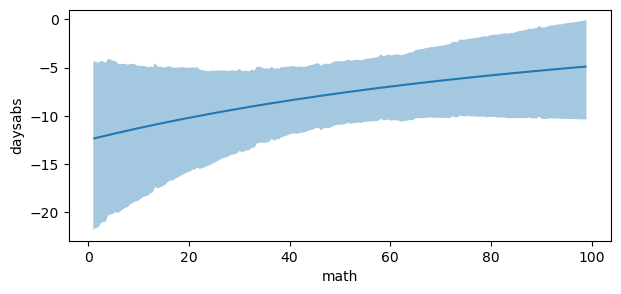

In [174]:
# default vals for numeric conditional variables
fig, ax = plot_comparison(
    model=model_interaction,
    idata=idata_interaction,
    contrast={"prog": ["General", "Vocational"]},
    conditional="math",
)
fig.set_size_inches(7, 3)

In [245]:
comparisons(
    model=model_interaction,
    idata=idata_interaction,
    contrast={"prog": ["Academic", "General"]},
    conditional="math"
)

,math,term,contrast,estimate,hdi_3%,hdi_97%
0,1.000000,prog,"[Academic, General]",5.705757,-2.780949,15.583213
1,1.492462,prog,"[Academic, General]",5.678390,-2.237369,15.903185
2,1.984925,prog,"[Academic, General]",5.651256,-2.166023,15.727247
3,2.477387,prog,"[Academic, General]",5.624354,-2.104542,15.566191
4,2.969849,prog,"[Academic, General]",5.597680,-2.137500,15.340540
...,...,...,...,...,...,...
195,97.030151,prog,"[Academic, General]",3.159759,-1.772281,8.687821
196,97.522614,prog,"[Academic, General]",3.155537,-1.894218,8.634422
197,98.015076,prog,"[Academic, General]",3.151369,-1.967486,8.615905
198,98.507538,prog,"[Academic, General]",3.147253,-1.930721,8.692068


In [315]:
# if the user wants to compare > 2 levels. Use the comparison function directly
df = comparisons(
    model=model_interaction,
    idata=idata_interaction,
    contrast="prog",
    conditional="math"
)
df["contrast"] = df["contrast"].apply(lambda x: str(x))
df

,math,term,contrast,estimate,hdi_3%,hdi_97%
0,1.000000,prog,"['Academic', 'General']",5.705757,-2.780949,15.583213
1,1.000000,prog,"['Academic', 'Vocational']",5.678390,-2.237369,15.903185
2,1.000000,prog,"['General', 'Vocational']",5.651256,-2.166023,15.727247
3,1.492462,prog,"['Academic', 'General']",5.624354,-2.104542,15.566191
4,1.492462,prog,"['Academic', 'Vocational']",5.597680,-2.137500,15.340540
...,...,...,...,...,...,...
595,98.507538,prog,"['Academic', 'Vocational']",-4.975379,-10.356706,-0.265434
596,98.507538,prog,"['General', 'Vocational']",-4.953374,-10.354091,-0.211429
597,99.000000,prog,"['Academic', 'General']",-4.931466,-10.382592,-0.191101
598,99.000000,prog,"['Academic', 'Vocational']",-4.909654,-10.369010,-0.098217


### Zero Inflated Poisson

In [31]:
fish_data = pd.read_stata("http://www.stata-press.com/data/r11/fish.dta")
cols = ["count", "livebait", "camper", "persons", "child"]
fish_data = fish_data[cols]

# convert livebait and camper to categorical
fish_data["livebait"] = fish_data["livebait"].astype("category")
fish_data["camper"] = fish_data["camper"].astype("category")
#fish_data["persons"] = pd.Categorical(fish_data["persons"], ordered=True)
#fish_data["child"] = pd.Categorical(fish_data["child"], ordered=True)

In [32]:
fish_data.describe().T

,count,mean,std,min,25%,50%,75%,max
count,250.0,3.296,11.635028,0.0,0.0,0.0,2.0,149.0
persons,250.0,2.528,1.112730,1.0,2.0,2.0,4.0,4.0
child,250.0,0.684,0.850315,0.0,0.0,0.0,1.0,3.0


In [178]:
likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
links = {"mu": "log", "psi": "logit"}
zip_family = bmb.Family("zip", likelihood, links)
zip_family

Family: zip
Likelihood: Likelihood(  
  name: ZeroInflatedPoisson,
  params: ['mu', 'psi'],
  parent: mu,
  dist: None
)
Link: {'mu': Link(  
  name: log,
  link: <ufunc 'log'>,
  linkinv: <ufunc 'exp'>
), 'psi': Link(  
  name: logit,
  link: <function logit at 0x16e7f6520>,
  linkinv: <function expit at 0x16e7f6480>
)}

In [179]:
priors = {"psi": bmb.Prior("Beta", alpha=3, beta=3)}
fish_model = bmb.Model(
    "count ~ livebait + camper + persons + child", 
    fish_data, 
    priors=priors,
    family=zip_family
)

In [180]:
fish_idata = fish_model.fit(
    draws=1000, target_accept=0.95, random_seed=1234, chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_psi, Intercept, livebait, camper, persons, child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [181]:
az.summary(fish_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.556,0.288,-3.093,-2.024,0.005,0.004,3360.0,2685.0,1.0
livebait[1.0],1.732,0.242,1.275,2.172,0.004,0.003,3830.0,2381.0,1.0
camper[1.0],0.674,0.095,0.492,0.845,0.001,0.001,4447.0,2735.0,1.0
persons,0.875,0.044,0.796,0.960,0.001,0.001,3528.0,2819.0,1.0
child,-1.394,0.094,-1.581,-1.226,0.002,0.001,3046.0,2921.0,1.0
count_psi,0.614,0.045,0.530,0.695,0.001,0.001,3895.0,2825.0,1.0


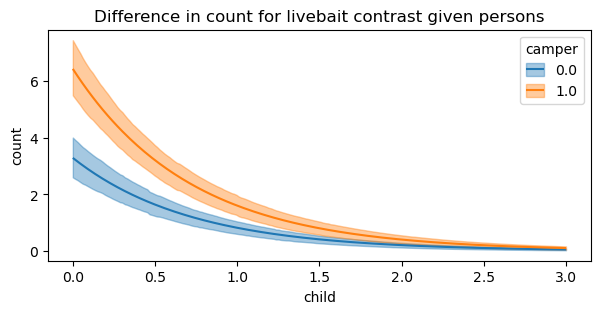

In [193]:
# default vals for both numeric contrast and conditional variables
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=["child", "camper"]
) 
fig.set_size_inches(7, 3)
plt.title("Difference in count for livebait contrast given persons");